# 乘用车销量预测

非常典型的回归预测问题。

难点就在给定一个时间序列，该怎么构造特征，构造哪些特征！ 这些都是通用的，可以用到任何的时间序列回归问题。

如果一个特征的取值范围大，或者有异常值，如何处理？  取log可以显著的减小异常值的影响



关于数据划分：

时序数据的预测应该是过去预测未来，切忌打乱后随机取一定的比例进行预测，因为这样会有泄漏问题

# 乘用车细分市场销量预测

https://www.datafountain.cn/competitions/352/datasets

## 数据说明 Data description
历史销量数据包含60个车型在22个省份，从2016年1月至2017年12月的销量。

参赛队伍需要预测接下来4个月（2018年1月至2018年4月），这60个车型在22个省份的销量；

参赛参赛队伍需自行划分训练集数据进行建模。  

[训练集]
### 历史销量数据：train_sales_data_v1.csv

    province	String	省份
    adcode	int	省份编码
    model	String	车型编码
    bodyType	String	车身类型
    regYear	int	年
    regMonth	int	月
    salesVolume	int	销量

### 车型搜索数据：train_search_data_v1.csv

    province	String	省份
    adcode	int	省份编码
    model	String	车型编码
    regYear	int	年
    regMonth	int	月
    popularity	int	搜索量

### 汽车垂直媒体新闻评论数据和车型评论数据：train_user_reply_data_v1.csv

    model	String	车型编码
    regYear	int	年
    regMonth	int	月
    newsReplyVolum	int	对车型相关新闻文章的评论数量
    carCommentVolum	int	对车型的评价数量

[评测集]
### 2018年1月至4月的各车型各省份销量预测：evaluation_public.csv

    id	int	数据的唯一标识，不可更改
    province	String	省份
    adcode	int	省份编码改
    model	String	车型编码
    regYear	int	年
    regMonth	int	月
    forecastVolum	int	预测销量，参赛队伍使用建立的模型得出的销量预测结果 Forecast sales volume— the results of sales forecasting obtained by the team using the established model

# EDA

In [3]:
import seaborn as sns
sns.set(font='Arial Unicode MS')  # 解决Seaborn中文显示问题

import sys
sys.path.append('/Users/luoyonggui/PycharmProjects/mayiutils_n1/mayiutils/data_prepare')

from data_explore import DataExplore as de

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option('expand_frame_repr', False)  # 当列太多时不自动换行

## train_sales_data.csv & train_search_data.csv

In [5]:
df_sales = pd.read_csv('data_origin/train/train_sales_data.csv')

df_sales.head()

,province,adcode,model,bodyType,regYear,regMonth,salesVolume
0,上海,310000,3c974920a76ac9c1,SUV,2016,1,292
1,云南,530000,3c974920a76ac9c1,SUV,2016,1,466
2,内蒙古,150000,3c974920a76ac9c1,SUV,2016,1,257
3,北京,110000,3c974920a76ac9c1,SUV,2016,1,408
4,四川,510000,3c974920a76ac9c1,SUV,2016,1,610


In [6]:
de.describe(df_sales)

num of records: 31680, num of columns: 7


,Data Type,Unique Values,count Missing,% Missing,Mode,Count Mode,% Mode,mean,std,min,25%,50%,75%,max
province,object,22,0,0.0,上海,1440,4.54545,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adcode,int64,22,0,0.0,110000,1440,4.54545,347727,136282,110000,230000,355000,440000,610000
model,object,60,0,0.0,02aab221aabc03b9,528,1.66667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bodyType,object,4,0,0.0,Sedan,14256,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regYear,int64,2,0,0.0,2016,15840,50,2016.5,0.500008,2016,2016,2016.5,2017,2017
regMonth,int64,12,0,0.0,1,2640,8.33333,6.5,3.45211,1,3.75,6.5,9.25,12
salesVolume,int64,2965,0,0.0,105,73,0.230429,608.709,779.077,2,182,363,737,15317


### province和adcode是一一对应的

In [7]:
df_sales[['province']].drop_duplicates().shape

(22, 1)

In [8]:
df_sales[['adcode']].drop_duplicates().shape

(22, 1)

In [9]:
df_sales[['province', 'adcode']].drop_duplicates().shape

(22, 2)

### model和bodyType是多对一的关系
即一个bodyType有多个编码

In [10]:
df_sales[['model']].drop_duplicates().shape

(60, 1)

In [11]:
df_sales[['bodyType']].drop_duplicates().shape

(4, 1)

In [12]:
df_sales[['model', 'bodyType']].drop_duplicates().shape

(60, 2)

In [13]:
df_sales['t'] = 0
df_sales.loc[df_sales.regYear==2017, 't'] = 12
df_sales['order'] = df_sales.t + df_sales.regMonth

In [14]:
df_sales.shape

(31680, 9)

In [15]:
df_search = pd.read_csv('data_origin/train/train_search_data.csv')

df_search.head()

,province,adcode,model,regYear,regMonth,popularity
0,河南,410000,17bc272c93f19d56,2016,1,19036
1,河南,410000,17bc272c93f19d56,2016,2,17856
2,河南,410000,17bc272c93f19d56,2016,3,12517
3,河南,410000,17bc272c93f19d56,2016,4,9700
4,河南,410000,17bc272c93f19d56,2016,5,12780


In [16]:
de.describe(df_search)

num of records: 31680, num of columns: 6


,Data Type,Unique Values,count Missing,% Missing,Mode,Count Mode,% Mode,mean,std,min,25%,50%,75%,max
province,object,22,0,0.0,上海,1440,4.54545,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adcode,int64,22,0,0.0,110000,1440,4.54545,347727,136282,110000,230000,355000,440000,610000
model,object,60,0,0.0,02aab221aabc03b9,528,1.66667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regYear,int64,2,0,0.0,2016,15840,50,2016.5,0.500008,2016,2016,2016.5,2017,2017
regMonth,int64,12,0,0.0,1,2640,8.33333,6.5,3.45211,1,3.75,6.5,9.25,12
popularity,int64,7239,0,0.0,859,26,0.0820707,2311.97,2980.55,25,700,1445.5,2816,116300


In [17]:
df_search.shape

(31680, 6)

In [18]:
df = pd.merge(df_sales, df_search, on='province adcode model regYear regMonth'.split())

In [19]:
df.shape

(31680, 10)

In [20]:
df.head()

,province,adcode,model,bodyType,regYear,regMonth,salesVolume,t,order,popularity
0,上海,310000,3c974920a76ac9c1,SUV,2016,1,292,0,1,1479
1,云南,530000,3c974920a76ac9c1,SUV,2016,1,466,0,1,1594
2,内蒙古,150000,3c974920a76ac9c1,SUV,2016,1,257,0,1,1479
3,北京,110000,3c974920a76ac9c1,SUV,2016,1,408,0,1,2370
4,四川,510000,3c974920a76ac9c1,SUV,2016,1,610,0,1,3562


In [21]:
df['popularity salesVolume'.split()].corr()

,popularity,salesVolume
popularity,1.000000,0.474152
salesVolume,0.474152,1.000000


In [15]:
# 每个省份都有60个车型
def t(s):
    return s.nunique()

df_sales.groupby('province')['model'].agg(t)

province
上海     60
云南     60
内蒙古    60
北京     60
四川     60
安徽     60
山东     60
山西     60
广东     60
广西     60
江苏     60
江西     60
河北     60
河南     60
浙江     60
湖北     60
湖南     60
福建     60
辽宁     60
重庆     60
陕西     60
黑龙江    60
Name: model, dtype: int64

## 分析影响销量的因素
* province
* regMonth
* bodyType
* regYear

可以看出，regYear的影响略弱，province、regMonth、bodyType的影响都较强

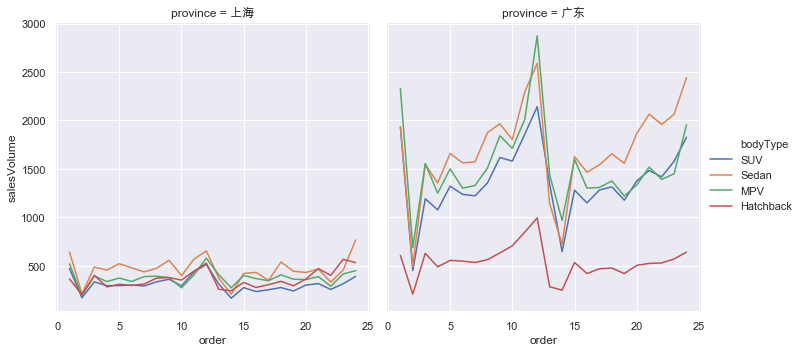

In [47]:
sns.relplot(x='order', y='salesVolume', hue='bodyType', col='province', kind='line', ci=None, height=5, data=df_sales[df_sales.province.isin(['上海', '广东'])])

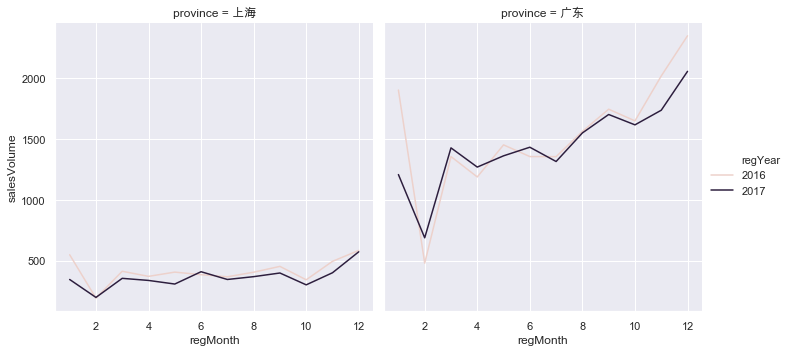

In [44]:
sns.relplot(x='regMonth', y='salesVolume', hue='regYear', col='province', kind='line', ci=None, height=5, data=df_sales[df_sales.province.isin(['上海', '广东'])])

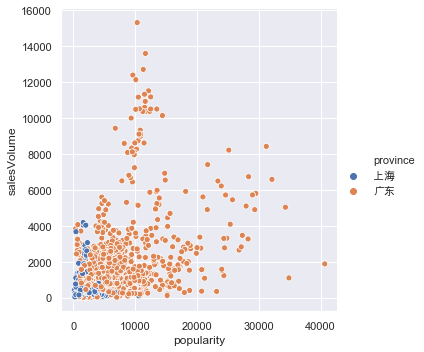

In [72]:
sns.relplot(x='popularity', y='salesVolume', hue='province', ci=None, height=5, data=df[df.province.isin(['上海', '广东'])])

### 搜索量和销量的关系
通过如下分析，没有发现搜索量和销量有明显的线性相关性

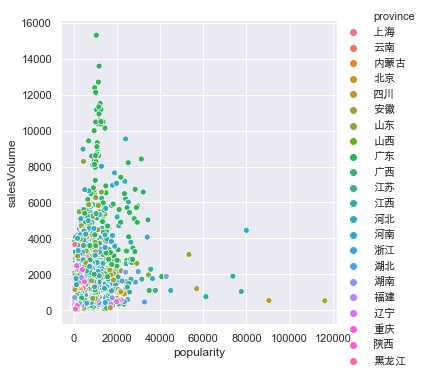

In [73]:
sns.relplot(x='popularity', y='salesVolume', hue='province', ci=None, height=5, data=df)

In [74]:
# 截断异常值
df.loc[df.popularity>40000, 'popularity'] = 40000

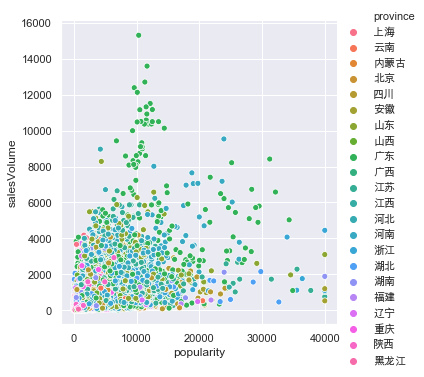

In [75]:
sns.relplot(x='popularity', y='salesVolume', hue='province', ci=None, height=5, data=df)

In [8]:
df_sales.regYear.unique()

array([2016, 2017])

## train_user_reply_data.csv

In [22]:
df_user_reply = pd.read_csv('data_origin/train/train_user_reply_data.csv')

df_user_reply.head()

,model,regYear,regMonth,carCommentVolum,newsReplyVolum
0,02aab221aabc03b9,2016,1,132,399
1,02aab221aabc03b9,2016,2,160,3043
2,02aab221aabc03b9,2016,3,357,798
3,02aab221aabc03b9,2016,4,243,3821
4,02aab221aabc03b9,2016,5,283,933


In [23]:
de.describe(df_user_reply)

num of records: 1440, num of columns: 5


,Data Type,Unique Values,count Missing,% Missing,Mode,Count Mode,% Mode,mean,std,min,25%,50%,75%,max
model,object,60,0,0.0,02aab221aabc03b9,24,1.66667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regYear,int64,2,0,0.0,2016,720,50,2016.5,0.500174,2016,2016,2016.5,2017,2017
regMonth,int64,12,0,0.0,1,120,8.33333,6.5,3.45325,1,3.75,6.5,9.25,12
carCommentVolum,int64,571,0,0.0,1,12,0.833333,250.479,318.755,0,54,149.5,307,2834
newsReplyVolum,int64,1159,0,0.0,0,18,1.25,1989.81,2325.29,0,335,1432.5,2712,20770


In [24]:
df_user_reply.shape

(1440, 5)

In [25]:
dfg = df_sales.groupby('model regYear regMonth'.split())['salesVolume'].sum()
dfg.head()

model             regYear  regMonth
02aab221aabc03b9  2016     1           10582
                           2            5084
                           3            8726
                           4            8286
                           5            8537
Name: salesVolume, dtype: int64

In [26]:
dft = pd.merge(df_user_reply, dfg, left_on='model regYear regMonth'.split(), right_index=True)

In [27]:
dft.head()

,model,regYear,regMonth,carCommentVolum,newsReplyVolum,salesVolume
0,02aab221aabc03b9,2016,1,132,399,10582
1,02aab221aabc03b9,2016,2,160,3043,5084
2,02aab221aabc03b9,2016,3,357,798,8726
3,02aab221aabc03b9,2016,4,243,3821,8286
4,02aab221aabc03b9,2016,5,283,933,8537


In [28]:
dft['carCommentVolum newsReplyVolum salesVolume'.split()].corr()

,carCommentVolum,newsReplyVolum,salesVolume
carCommentVolum,1.000000,0.137289,0.269024
newsReplyVolum,0.137289,1.000000,0.200783
salesVolume,0.269024,0.200783,1.000000


### 对车型相关新闻文章的评论数量和销量的关系
看不出明显的线性相关性

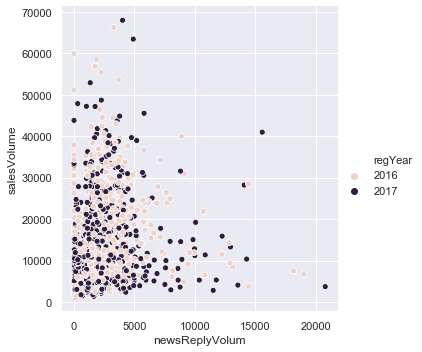

In [81]:
sns.relplot(x='newsReplyVolum', y='salesVolume', hue='regYear', ci=None, height=5, data=dft)

### 对车型的评价数量和销量的关系
看不出明显的线性相关性

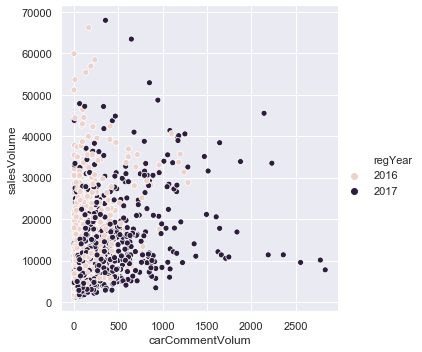

In [80]:
sns.relplot(x='carCommentVolum', y='salesVolume', hue='regYear', ci=None, height=5, data=dft)

## evaluation_public.csv

In [4]:
df_test = pd.read_csv('data_origin/evaluation_public.csv', index_col=0)
df_test.head()

,province,adcode,model,regYear,regMonth,forecastVolum
id,,,,,,
1,上海,310000,3c974920a76ac9c1,2018,1,NaN
2,云南,530000,3c974920a76ac9c1,2018,1,NaN
3,内蒙古,150000,3c974920a76ac9c1,2018,1,NaN
4,北京,110000,3c974920a76ac9c1,2018,1,NaN
5,四川,510000,3c974920a76ac9c1,2018,1,NaN


## EDA总结
### 通过规则做
把影响较大的几个因素的影响分离出来，剩下的序列平稳，然后做预测

### 用boost做一下
